# Train Predict Next Play Model

In [1]:
import os
import torch
import torch.nn as nn
import pandas as pd
from sklearn.model_selection import train_test_split

from train_tools import SCALER_SUFFIX

from train_tools import acquire_data
from train_tools import scale_int_values, extract_categorical_columns
from train_tools import replace_populated_values_with_tf_num
from train_tools import model_train, save_model, evaluate_model

In [2]:
output_dir = "../../../target/models/predict_play/"
onnx_path = os.path.join(output_dir, "model.onnx")
roc_path = os.path.join(output_dir, "roc.jpg")
dataset_size = 5000
db_conn_str = "postgresql://baseball_app:baseball123@db/baseball_db"
neural_network_width = 10


In [3]:
output_dir = os.path.abspath(output_dir)
print ("Output Directory: " + output_dir)

# ensure the model directory exists
if not os.path.exists(output_dir):
    print ("Creating output directory: " + output_dir)
    os.makedirs(output_dir)

Output Directory: /opt/app-root/src/baseball/target/models/predict_play


## Acquire Data

Pull relevant attributes from the baseball database as a DataFrame for analysis and training.

In [4]:
if dataset_size is not None and isinstance(dataset_size, str) and len(dataset_size) > 0:
    dataset_size = int(dataset_size)
print ("Data Set Size: " + str(dataset_size))

Data Set Size: 5000


In [5]:
sql = """
        select random() as r_id, game_play_atbat.player_code as player_code, pitch_index, home_team_flag, 
               game_play_atbat.score_home as score_home, game_play_atbat.score_visitor as score_visitor, 
               sky, night_flag, temperature, wind_direction, wind_speed, precipitation, field_condition, 
               roster_batter.batting_hand as batting_hand, roster_pitcher.throw_hand as pitching_hand, 
               runner_1b, runner_2b, runner_3b, primary_play_type_cd, outs, pitch_count_end as pitch_count
        from game, game_play, game_play_atbat, game_play_atbat_pitch, roster as roster_batter, roster as roster_pitcher
        where game.game_id = game_play.game_id
        and game_play_atbat.game_play_id = game_play.game_play_id
        and game_play_atbat_pitch.game_play_id = game_play.game_play_id     
        and roster_batter.player_code = game_play_atbat.player_code
        and roster_batter.season_year = date_part('year', game.game_date)
        and roster_pitcher.player_code = game_play_atbat.pitcher
        and roster_pitcher.season_year = roster_batter.season_year
        order by r_id        
      """

full_df = acquire_data(db_conn_str, sql, dataset_size)

full_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 21 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   r_id                  5000 non-null   float64
 1   player_code           5000 non-null   object 
 2   pitch_index           5000 non-null   int64  
 3   home_team_flag        5000 non-null   bool   
 4   score_home            5000 non-null   int64  
 5   score_visitor         5000 non-null   int64  
 6   sky                   5000 non-null   object 
 7   night_flag            5000 non-null   bool   
 8   temperature           5000 non-null   int64  
 9   wind_direction        5000 non-null   object 
 10  wind_speed            5000 non-null   int64  
 11  precipitation         5000 non-null   object 
 12  field_condition       5000 non-null   object 
 13  batting_hand          5000 non-null   object 
 14  pitching_hand         5000 non-null   object 
 15  runner_1b            

In [6]:
def calculate_score_deficit(row):
    is_home = row["home_team_flag"]
    score_home = row["score_home"]
    score_visitor = row["score_visitor"]

    if is_home:
        return score_home - score_visitor
    else:
        return score_visitor - score_home

full_df['score_deficit'] = full_df.apply(lambda x: calculate_score_deficit(x), axis=1)

In [7]:
full_df.head()

,r_id,player_code,pitch_index,home_team_flag,score_home,score_visitor,sky,night_flag,temperature,wind_direction,...,field_condition,batting_hand,pitching_hand,runner_1b,runner_2b,runner_3b,primary_play_type_cd,outs,pitch_count,score_deficit
0,1.108781e-07,longt002,6,True,8,3,sunny,True,65,torf,...,unknown,L,L,longt002,None,None,W,0,29,5
1,2.360094e-07,freed001,2,True,0,2,unknown,True,81,fromcf,...,unknown,R,R,freed001,None,None,W,0,91,-2
2,3.836542e-07,suzui001,2,True,1,1,unknown,True,80,tocf,...,unknown,R,R,None,morsm001,yelic001,K,3,108,0
3,4.124658e-07,mendd001,6,False,0,0,cloudy,True,63,torf,...,unknown,R,R,None,None,None,D,3,40,0
4,8.042845e-07,brows003,2,True,5,7,sunny,True,88,unknown,...,unknown,L,R,lowrj001,None,None,K,2,45,-2


## Prepare Data for Model Training

Prepare data for classification.

In [8]:
# focus data frame on prediction values
# - maybes - wind_direction, home_team_flag, night_flag
df = full_df[["pitch_index", "pitch_count", "batting_hand", "pitching_hand", "runner_1b", "runner_2b", "runner_3b", "outs", "score_deficit", "primary_play_type_cd"]]

df = df.convert_dtypes()
df.head()

,pitch_index,pitch_count,batting_hand,pitching_hand,runner_1b,runner_2b,runner_3b,outs,score_deficit,primary_play_type_cd
0,6,29,L,L,longt002,<NA>,<NA>,0,5,W
1,2,91,R,R,freed001,<NA>,<NA>,0,-2,W
2,2,108,R,R,<NA>,morsm001,yelic001,3,0,K
3,6,40,R,R,<NA>,<NA>,<NA>,3,0,D
4,2,45,L,R,lowrj001,<NA>,<NA>,2,-2,K


In [9]:
scale_int_values(df, 'pitch_index', 'pitch_index_scaled', True,
                 output_dir + "/" + "pitch_index" + SCALER_SUFFIX)
scale_int_values(df, 'pitch_count', 'pitch_count_scaled', True,
                 output_dir + "/" + "pitch_count" + SCALER_SUFFIX)
scale_int_values(df, 'score_deficit', 'score_deficit_scaled', True,
                 output_dir + "/" + "score_deficit" + SCALER_SUFFIX)

replace_populated_values_with_tf_num(df, 'runner_1b', 'is_runner_1b', True)
replace_populated_values_with_tf_num(df, 'runner_2b', 'is_runner_2b', True)
replace_populated_values_with_tf_num(df, 'runner_3b', 'is_runner_3b', True)

df = extract_categorical_columns(df, ["batting_hand", "pitching_hand", "outs", "primary_play_type_cd"])

df.head()


,pitch_index_scaled,pitch_count_scaled,score_deficit_scaled,is_runner_1b,is_runner_2b,is_runner_3b,batting_hand_L,batting_hand_R,pitching_hand_B,pitching_hand_L,...,primary_play_type_cd_G,primary_play_type_cd_H,primary_play_type_cd_I,primary_play_type_cd_K,primary_play_type_cd_L,primary_play_type_cd_N,primary_play_type_cd_O,primary_play_type_cd_P,primary_play_type_cd_W,primary_play_type_cd_X
0,1.427019,-0.480840,1.591305,1,0,0,True,False,False,True,...,False,False,False,False,False,False,False,False,True,False
1,-0.573569,1.085907,-0.600662,1,0,0,False,True,False,False,...,False,False,False,False,False,False,False,False,True,False
2,-0.573569,1.515499,0.025615,0,1,1,False,True,False,False,...,False,False,False,True,False,False,False,False,False,False
3,1.427019,-0.202868,0.025615,0,0,0,False,True,False,False,...,False,False,False,False,False,False,False,False,False,False
4,-0.573569,-0.076518,-0.600662,1,0,0,True,False,False,False,...,False,False,False,True,False,False,False,False,False,False


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 43 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   pitch_index_scaled      5000 non-null   float64
 1   pitch_count_scaled      5000 non-null   float64
 2   score_deficit_scaled    5000 non-null   float64
 3   is_runner_1b            5000 non-null   int64  
 4   is_runner_2b            5000 non-null   int64  
 5   is_runner_3b            5000 non-null   int64  
 6   batting_hand_L          5000 non-null   boolean
 7   batting_hand_R          5000 non-null   boolean
 8   pitching_hand_B         5000 non-null   boolean
 9   pitching_hand_L         5000 non-null   boolean
 10  pitching_hand_R         5000 non-null   boolean
 11  outs_0                  5000 non-null   bool   
 12  outs_1                  5000 non-null   bool   
 13  outs_2                  5000 non-null   bool   
 14  outs_3                  5000 non-null   

## Train Model

Train a classification model using the prepared data set.

In [11]:
df["pitch_index_scaled"].describe()

count    5.000000e+03
mean     8.952838e-17
std      1.000100e+00
min     -1.073715e+00
25%     -5.735685e-01
50%     -7.342157e-02
75%      4.267254e-01
max      5.428195e+00
Name: pitch_index_scaled, dtype: float64

In [12]:
size_x = 15
size_y = df.shape[1] - size_x
print(f"Number of Features (X): {size_x}")
print(f"Length of Outputs (y): {size_y}")

print("Columns and their respective order for inferences:")
df.columns[0:size_x]

Number of Features (X): 15
Length of Outputs (y): 28
Columns and their respective order for inferences:


Index(['pitch_index_scaled', 'pitch_count_scaled', 'score_deficit_scaled',
       'is_runner_1b', 'is_runner_2b', 'is_runner_3b', 'batting_hand_L',
       'batting_hand_R', 'pitching_hand_B', 'pitching_hand_L',
       'pitching_hand_R', 'outs_0', 'outs_1', 'outs_2', 'outs_3'],
      dtype='object')

In [13]:
df = df.convert_dtypes()
print("Model Inputs:")
df.info()

# Extract data
X = df.iloc[:, 0:size_x]
y = df.iloc[:, size_x:]

Model Inputs:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 43 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   pitch_index_scaled      5000 non-null   Float64
 1   pitch_count_scaled      5000 non-null   Float64
 2   score_deficit_scaled    5000 non-null   Float64
 3   is_runner_1b            5000 non-null   Int64  
 4   is_runner_2b            5000 non-null   Int64  
 5   is_runner_3b            5000 non-null   Int64  
 6   batting_hand_L          5000 non-null   boolean
 7   batting_hand_R          5000 non-null   boolean
 8   pitching_hand_B         5000 non-null   boolean
 9   pitching_hand_L         5000 non-null   boolean
 10  pitching_hand_R         5000 non-null   boolean
 11  outs_0                  5000 non-null   boolean
 12  outs_1                  5000 non-null   boolean
 13  outs_2                  5000 non-null   boolean
 14  outs_3                  50

In [14]:
# Convert to 2D PyTorch tensors
Xt = torch.tensor(X.values.astype(float), dtype=torch.float32)
yt = torch.tensor(y.values.astype(bool), dtype=torch.float32)


In [15]:
class PlayPredictionModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = nn.Linear(size_x, size_x*neural_network_width)
        self.act1 = nn.ReLU()
        self.layer2 = nn.Linear(size_x*neural_network_width, size_x*neural_network_width)
        self.act2 = nn.ReLU()
        self.layer3 = nn.Linear(size_x*neural_network_width, size_x*neural_network_width)
        self.act3 = nn.ReLU()
        self.output = nn.Linear(size_x*neural_network_width, size_y)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.act1(self.layer1(x))
        x = self.act2(self.layer2(x))
        x = self.act3(self.layer3(x))
        x = self.sigmoid(self.output(x))
        return x

In [16]:
X_train, X_test, y_train, y_test = train_test_split(Xt, yt, train_size=0.7, shuffle=True)
print ("Training Shapes: X_train=" + str(X_train.shape) + " y_train=" + str(y_train.shape) + " X_test=" + str(X_test.shape) + " y_test=" + str(y_test.shape))

Training Shapes: X_train=torch.Size([3500, 15]) y_train=torch.Size([3500, 28]) X_test=torch.Size([1500, 15]) y_test=torch.Size([1500, 28])


In [17]:
model = PlayPredictionModel()
final_acc = model_train(model, X_train, y_train, X_test, y_test)
print(f"Final model accuracy: {final_acc*100:.2f}%")

Epoch 49: 100%|██████████| 350/350 [00:03<00:00, 102.80batch/s, acc=0.979, loss=0.0627]


Final model accuracy: 96.91%


ROC Image Output Filename: /opt/app-root/src/baseball/target/models/predict_play/roc.jpg
Model Outputs:
['outs_4' 'outs_5' 'outs_6' 'outs_8' 'outs_11' 'outs_12' 'outs_13'
 'outs_15' 'outs_20' 'primary_play_type_cd_0' 'primary_play_type_cd_1'
 'primary_play_type_cd_2' 'primary_play_type_cd_3'
 'primary_play_type_cd_A' 'primary_play_type_cd_B'
 'primary_play_type_cd_C' 'primary_play_type_cd_D'
 'primary_play_type_cd_E' 'primary_play_type_cd_G'
 'primary_play_type_cd_H' 'primary_play_type_cd_I'
 'primary_play_type_cd_K' 'primary_play_type_cd_L'
 'primary_play_type_cd_N' 'primary_play_type_cd_O'
 'primary_play_type_cd_P' 'primary_play_type_cd_W'
 'primary_play_type_cd_X']
[-1.0737154   0.883746   -0.91379964  1.          0.          0.
  0.          1.          0.          0.          1.          0.
  1.          0.          0.        ] -> [1.11576492e-09 1.83765122e-04 3.24162247e-04 1.33689182e-05
 3.00423790e-06 2.82244696e-06 8.43416492e-05 8.65564143e-05
 6.75205225e-09 5.12170518e-05

/opt/app-root/lib64/python3.11/site-packages/sklearn/metrics/_ranking.py:1183: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/opt/app-root/lib64/python3.11/site-packages/sklearn/metrics/_ranking.py:1183: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/opt/app-root/lib64/python3.11/site-packages/sklearn/metrics/_ranking.py:1183: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/opt/app-root/lib64/python3.11/site-packages/sklearn/metrics/_ranking.py:1183: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/opt/app-root/lib64/python3.11/site-packages/sklearn/metrics/_ranking.py:1183: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/opt/app-root/lib64/python3.11/site

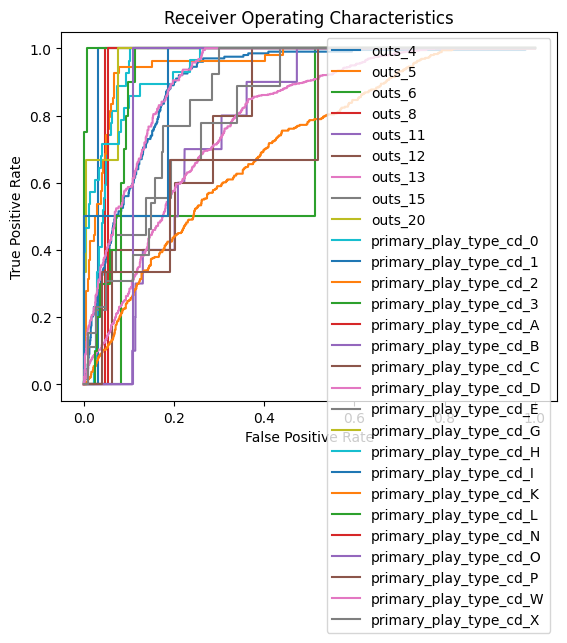

In [21]:
roc_path = os.path.abspath(roc_path)
print("ROC Image Output Filename: " + roc_path)

db_conn_str_sqlalchamy = db_conn_str.replace("postgresql://", "postgresql+psycopg://")
play_types_df = pd.read_sql("select play_type_cd, play_type_desc from play_type order by play_type_cd", db_conn_str_sqlalchamy)

y_column_names = df.columns[size_x:].values
#y_column_descriptions = [play_types_df.loc[play_types_df['play_type_cd'] == c.replace("primary_play_type_cd_", ""), 'play_type_desc'].values[0] for c in y_column_names ]
y_column_descriptions = y_column_names

print("Model Outputs:")
print (y_column_descriptions)

evaluate_model(model, X_test, y_test, roc_path, y_column_descriptions)

## Save the model

Save the model to disk for use by an inference service.

In [ ]:
onnx_path = os.path.abspath(onnx_path)
print ("ONNX Model Output Filename: " + onnx_path)
save_model(model, size_x, onnx_path)